# Synthesising all the results

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [46]:
# Datafiles
MODEL = "Qwen/Qwen2.5-7B-Instruct"  
model_short_name = "Qwen2.5-7B-Instruct"
data_dir = "./../output"
eurostat_data_files = [
    {
        "indicator": "income",
        "path_absolute": f"{data_dir}/income_2017_nuts_llm_{model_short_name}_absolute.csv",
        "path_relative": f"{data_dir}/income_2017_nuts_llm_{model_short_name}_relative.csv",
        "complete_year": "2017",
        "unit": "EUR_HAB"
    },
    {
        "indicator": "pop_density",
        "path_absolute": f"{data_dir}/pop_density_2018_nuts_llm_{model_short_name}_absolute.csv",
        "path_relative": f"{data_dir}/pop_density_2018_nuts_llm_{model_short_name}_relative.csv",
        "complete_year": "2018",
        "unit": "PER_KM2",
        "nan": ":", # null value are ":" and not empty cell
    },
    {
        "indicator": "poverty",
        "path_absolute": f"{data_dir}/poverty_2022_nuts_llm_{model_short_name}_absolute.csv",
        "path_relative": f"{data_dir}/poverty_2022_nuts_llm_{model_short_name}_relative.csv",
        "complete_year": "2022",
        "unit": "PC",
        "nan": ":"
    },
    {
        "indicator": "age_index",
        "path_absolute": f"{data_dir}/age_index_2021_nuts_llm_{model_short_name}_absolute.csv",
        "path_relative": f"{data_dir}/age_index_2021_nuts_llm_{model_short_name}_relative.csv",
        "complete_year": "2021",
        "unit": "NR"
    }
]


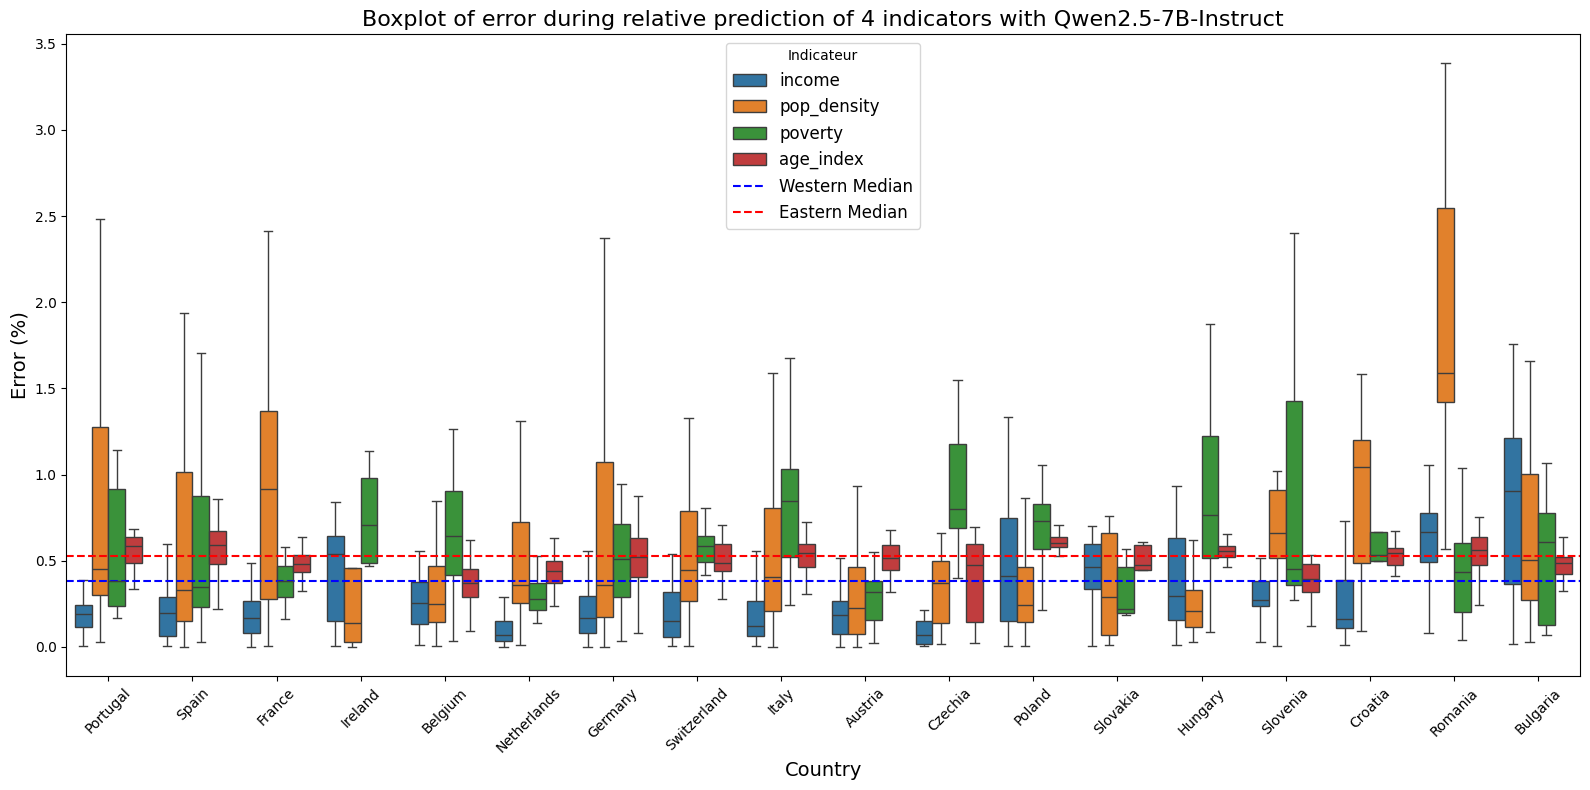

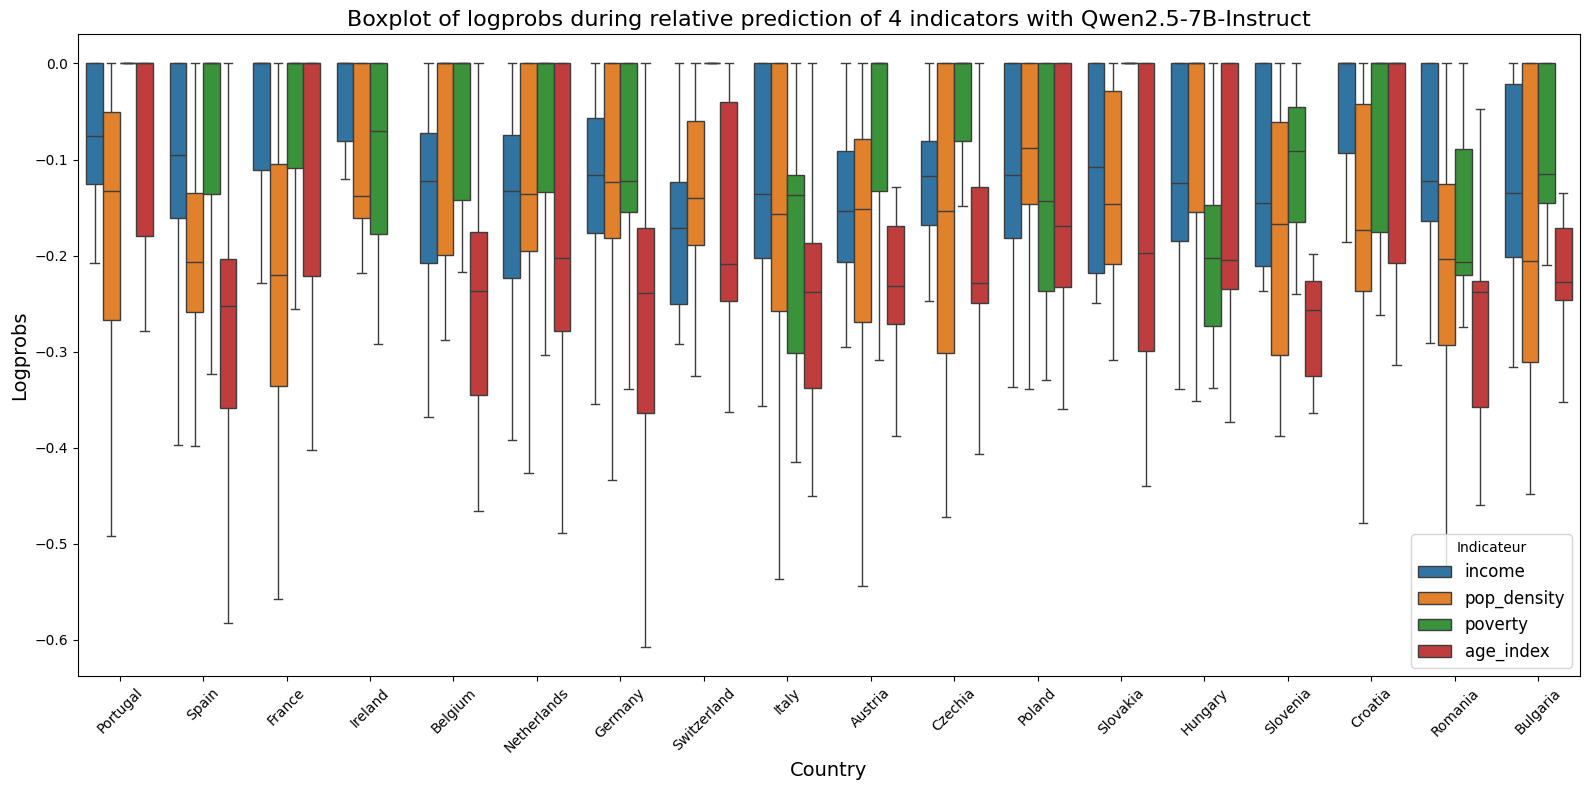

In [47]:
all_errors = []

for file_info in eurostat_data_files:
    indicator = file_info["indicator"]
    data = pd.read_csv(file_info["path_relative"])
    data[f"error"] = abs(data[f"{indicator}_relative_predicted"] - data[f"relative_{indicator}"]) / data[f"average_country_indicator"]
    data["logprobs"] = data[f'{indicator}_relative_logprobs']
    data["indicator"] = indicator
    
    # Append to the list
    all_errors.append(data[["country", f"error", 'logprobs', "indicator"]])

# Combine all data into a single DataFrame
combined_data = pd.concat(all_errors)
combined_data = combined_data.dropna(subset=["error"])
combined_data = combined_data.reset_index()

# Define geographic order of countries
geographic_order = [
    "Portugal", "Spain", "France", "Ireland", "United Kingdom", "Belgium", "Netherlands",
    "Germany", "Switzerland", "Italy", "Austria", "Czechia", "Poland",
    "Slovakia", "Hungary", "Slovenia", "Croatia", "Romania", "Bulgaria", "Greece"
]
western_countries = [
    "Portugal", "Spain", "France", "Ireland", "United Kingdom", "Belgium", 
    "Netherlands", "Germany", "Switzerland", "Italy", "Austria"
]
eastern_countries = [
    "Czechia", "Poland", "Slovakia", "Hungary", "Slovenia", 
    "Croatia", "Romania", "Bulgaria", "Greece"
]

countries_in_data = combined_data["country"].unique()
geographic_order_filtered = [country for country in geographic_order if country in countries_in_data]
western_median = combined_data[combined_data["country"].isin(western_countries)]["error"].median()
eastern_median = combined_data[combined_data["country"].isin(eastern_countries)]["error"].median()

# Create the boxplot
plt.figure(figsize=(16, 8))
sns.boxplot(
    x="country", y="error", hue="indicator", data=combined_data,
    order=geographic_order_filtered,
    showfliers=False
)
plt.axhline(y=western_median, color="blue", linestyle="--", label="Western Median")
plt.axhline(y=eastern_median, color="red", linestyle="--", label="Eastern Median")
# Customize the plot
plt.title(f"Boxplot of error during relative prediction of 4 indicators with {model_short_name}", fontsize=16)
plt.xlabel("Country", fontsize=14)
plt.ylabel("Error (%)", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Indicateur", fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()


western_median = combined_data[combined_data["country"].isin(western_countries)]["logprobs"].median()
eastern_median = combined_data[combined_data["country"].isin(eastern_countries)]["logprobs"].median()
plt.figure(figsize=(16, 8))
sns.boxplot(
    x="country", y="logprobs", hue="indicator", data=combined_data,
    order=geographic_order_filtered, 
    showfliers=False
)

# Customize the plot
plt.title(f"Boxplot of logprobs during relative prediction of 4 indicators with {model_short_name}", fontsize=16)
plt.xlabel("Country", fontsize=14)
plt.ylabel("Logprobs", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Indicateur", fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()

In [33]:
combined_data

,index,country,error,logprobs,indicator
0,0,Austria,0.011756,-0.199548,income
1,1,Austria,0.217106,-0.102809,income
2,2,Albania,0.829187,0.000000,income
3,3,Albania,2.990050,-0.190137,income
4,4,Albania,0.520177,0.000000,income
...,...,...,...,...,...
5173,1445,Sweden,0.195746,-0.226891,age_index
5174,1446,Slovenia,0.060398,-0.334513,age_index
5175,1447,Portugal,0.534204,0.000000,age_index
5176,1448,Slovakia,0.150588,0.000000,age_index
